## Overview

Using UNet to segment and count the cell from hologram images directly

### 0) Parameter Configuration

In [1]:
from __future__ import print_function,division

import warnings
warnings.filterwarnings("ignore")

class Config(object):
    """Base configuration class. For custom configurations, create a
    sub-class that inherits from this one and override properties
    that need to be changed.
    """ 
    # Image folder including ground truth and hologram images
    IMG_FOLDER = "/disk2/Faliu/pyTorch/holo/data/data40x/train"
    
    # Image size used for algorithm
    OUTPUT_SHAPE = (384,384)   #768
    
    # Base learning rate
    BASE_LR = 0.001
    
    # Batch size
    BATCH_SIZE = 4
    
    # Momentumn 
    MOMENTUM = 0.9
    
    # Weight decay
    WEIGH_DECAY = 0.001
    
    # Epoch number
    NUM_EPOCHES = 50
    
    # Num of GPU to use
    GPU_COUNT = 1
    
    # Use the specific GPU
    WHICH_GPU = 0
    
    # Num of channel
    NUM_CHANNEL = 8
    
    # Num of classes to be predicted
    NUM_CLASSES = 2
    
    # Folder to save the trained model
    MODEL_DIR = ""
    
    # Folder to save the prediction results
    RESULTS_DIR = ""
    
    # File of the pretrained model
    PRETRAIN_FILE = ""
    
    
    # Gaussin smoothing
    HAS_GAUSSIN_SMOOTHING = True
    
    # Resume Point
    RESUME_POINT = 0
    
    # num of workers used for data loading
    NUM_WORKERS = 4

    
    def __init__(self):
        "Nonthing"
        
    def display(self):
        """Display Configuration values."""
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))

### 1)UNet Algorithm Definition

In [2]:
from __future__ import print_function,division
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    """
    unet algorithm
    """
    def __init__(self,inputs,labels):
        super(UNet,self).__init__()
        
        self.inputs = inputs
        
        # encode1
        self.conv11 = nn.Conv2d(inputs, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64)
        
        # encode2
        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128)
        
        # encode3
        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(256)
        
        # encode4
        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(512)
        
        # encode5
        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53 = nn.BatchNorm2d(512)
        
        #=============================>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        
        # decode 5
        self.upconv5 = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv53d = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn53d = nn.BatchNorm2d(512)
        self.conv52d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52d = nn.BatchNorm2d(512)
        self.conv51d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51d = nn.BatchNorm2d(512)
        
        # decode 4
        self.upconv4 = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(512)
        self.conv42d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512)
        self.conv41d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(256)
        
        # decode 3
        self.upconv3 = nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(256)
        self.conv32d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256)
        self.conv31d = nn.Conv2d(256,  128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128)
        
        # decode 2
        self.upconv2 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128)
        self.conv21d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(64)
        
        # decode 1
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64)
        self.conv11d = nn.Conv2d(64, labels, kernel_size=3, padding=1)
        
    
    def forward(self,x):
        # encode 1
        x11 = F.relu(self.bn11(self.conv11(x)))
        x12 = F.relu(self.bn12(self.conv12(x11)))
        x1p = F.max_pool2d(x12, kernel_size=2, stride=2)
        
        # encode 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22 = F.relu(self.bn22(self.conv22(x21)))
        x2p = F.max_pool2d(x22, kernel_size=2, stride=2)
        
        # encode 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32 = F.relu(self.bn32(self.conv32(x31)))
        x33 = F.relu(self.bn33(self.conv33(x32)))
        x3p = F.max_pool2d(x33, kernel_size=2, stride=2)
        
        # encode 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42 = F.relu(self.bn42(self.conv42(x41)))
        x43 = F.relu(self.bn43(self.conv43(x42)))
        x4p = F.max_pool2d(x43, kernel_size=2, stride=2)
        
        # encode 5
        x51 = F.relu(self.bn51(self.conv51(x4p)))
        x52 = F.relu(self.bn52(self.conv52(x51)))
        x53 = F.relu(self.bn53(self.conv53(x52)))
        x5p = F.max_pool2d(x53, kernel_size=2, stride=2)
        
        # decode 5
        x5d = torch.cat((self.upconv5(x5p), x53), 1)
        x53d = F.relu(self.bn53d(self.conv53d(x5d)))
        x52d = F.relu(self.bn52d(self.conv52d(x53d)))
        x51d = F.relu(self.bn51d(self.conv51d(x52d)))
        
        # decode 4
        x4d = torch.cat((self.upconv4(x51d), x43), 1)
        x43d = F.relu(self.bn43d(self.conv43d(x4d)))
        x42d = F.relu(self.bn42d(self.conv42d(x43d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))
        
        # decode 3
        x3d = torch.cat((self.upconv3(x41d), x33), 1)
        x33d = F.relu(self.bn33d(self.conv33d(x3d)))
        x32d = F.relu(self.bn32d(self.conv32d(x33d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))
        
        # decode 2
        x2d = torch.cat((self.upconv2(x31d), x22), 1)
        x22d = F.relu(self.bn22d(self.conv22d(x2d)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))
        
        # decode 1
        x1d = torch.cat((self.upconv1(x21d), x12), 1)
        x12d = F.relu(self.bn12d(self.conv12d(x1d)))
        x11d = self.conv11d(x12d)
        
        return x11d
    
    
    def initialized_with_pretrained_weights(self):
        """Initialiaze."""
        corresp_name = {
                        "features.0.weight": "conv11.weight",
                        "features.0.bias": "conv11.bias",
                        "features.1.weight": "bn11.weight",
                        "features.1.bias": "bn11.bias",
                        "features.1.running_mean": "bn11.running_mean",
                        "features.1.running_var": "bn11.running_var",

                        "features.3.weight": "conv12.weight",
                        "features.3.bias": "conv12.bias",
                        "features.4.weight": "bn12.weight",
                        "features.4.bias": "bn12.bias",
                        "features.4.running_mean": "bn12.running_mean",
                        "features.4.running_var": "bn12.running_var",

                        "features.7.weight": "conv21.weight",
                        "features.7.bias": "conv21.bias",
                        "features.8.weight": "bn21.weight",
                        "features.8.bias": "bn21.bias",
                        "features.8.running_mean": "bn21.running_mean",
                        "features.8.running_var": "bn21.running_var",

                        "features.10.weight": "conv22.weight",
                        "features.10.bias": "conv22.bias",
                        "features.11.weight": "bn22.weight",
                        "features.11.bias": "bn22.bias",
                        "features.11.running_mean": "bn22.running_mean",
                        "features.11.running_var": "bn22.running_var",

                        # stage 3
                        "features.14.weight": "conv31.weight",
                        "features.14.bias": "conv31.bias",
                        "features.15.weight": "bn31.weight",
                        "features.15.bias": "bn31.bias",
                        "features.15.running_mean": "bn31.running_mean",
                        "features.15.running_var": "bn31.running_var",

                        "features.17.weight": "conv32.weight",
                        "features.17.bias": "conv32.bias",
                        "features.18.weight": "bn32.weight",
                        "features.18.bias": "bn32.bias",
                        "features.18.running_mean": "bn32.running_mean",
                        "features.18.running_var": "bn32.running_var",

                        "features.20.weight": "conv33.weight",
                        "features.20.bias": "conv33.bias",
                        "features.21.weight": "bn33.weight",
                        "features.21.bias": "bn33.bias",
                        "features.21.running_mean": "bn33.running_mean",
                        "features.21.running_var": "bn33.running_var",

                        # stage 4
                        "features.24.weight": "conv41.weight",
                        "features.24.bias": "conv41.bias",
                        "features.25.weight": "bn41.weight",
                        "features.25.bias": "bn41.bias",
                        "features.25.running_mean": "bn41.running_mean",
                        "features.25.running_var": "bn41.running_var",

                        "features.27.weight": "conv42.weight",
                        "features.27.bias": "conv42.bias",
                        "features.28.weight": "bn42.weight",
                        "features.28.bias": "bn42.bias",
                        "features.28.running_mean": "bn42.running_mean",
                        "features.28.running_var": "bn42.running_var",

                        "features.30.weight": "conv43.weight",
                        "features.30.bias": "conv43.bias",
                        "features.31.weight": "bn43.weight",
                        "features.31.bias": "bn43.bias",
                        "features.31.running_mean": "bn43.running_mean",
                        "features.31.running_var": "bn43.running_var",

                        # stage 5
                        "features.34.weight": "conv51.weight",
                        "features.34.bias": "conv51.bias",
                        "features.35.weight": "bn51.weight",
                        "features.35.bias": "bn51.bias",
                        "features.35.running_mean": "bn51.running_mean",
                        "features.35.running_var": "bn51.running_var",

                        "features.37.weight": "conv52.weight",
                        "features.37.bias": "conv52.bias",
                        "features.38.weight": "bn52.weight",
                        "features.38.bias": "bn52.bias",
                        "features.38.running_mean": "bn52.running_mean",
                        "features.38.running_var": "bn52.running_var",

                        "features.40.weight": "conv53.weight",
                        "features.40.bias": "conv53.bias",
                        "features.41.weight": "bn53.weight",
                        "features.41.bias": "bn53.bias",
                        "features.41.running_mean": "bn53.running_mean",
                        "features.41.running_var": "bn53.running_var",
                        }
        # load the state dict of pretrained model
        import torch.utils.model_zoo as model_zoo
        pretrained_sd = model_zoo.load_url("http://download.pytorch.org/models/vgg16_bn-6c64b313.pth")
        s_dict = self.state_dict()
        for name in pretrained_sd:
            if name not in corresp_name:
                continue
            if("features.0" not in name) or (self.inputs==3):
                s_dict[corresp_name[name]] = pretrained_sd[name]
        self.load_state_dict(s_dict)
        
    
    def load_from_filename(self,model_path):
        """Load weights from filename."""
        th = torch.load(model_path)  # .state_dict()  # load the weigths
        self.load_state_dict(th)        

### 3) Data Preparation

In [3]:
from glob import glob
import numpy as np
import cv2
import skimage.io
import torch
import pandas as pd
from skimage import io,transform
import skimage
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,utils
from PIL import Image
import imgaug as ia
from imgaug import augmenters as iaa
import random
from scipy.ndimage.filters import gaussian_filter
import os


class HoloDataset(Dataset):
    """
    Images from Hologram Dataset
    """
    def __init__(self,config,avg,std,has_augment=None):
        """
        Args:
            config: has all related parameters
            indicator: "train","val" or "test"
            avg,std: average and standard deviation value for the training dataset
            transform(callable,optional): image transform
        """
        self.image_folder = config.IMG_FOLDER
        self.output_shape = config.OUTPUT_SHAPE
        self.has_augment = has_augment
        self.avg,self.std = avg,std
        self.has_gaussian_smoothing = config.HAS_GAUSSIN_SMOOTHING
        self.mask_imgs = glob(self.image_folder + os.sep + 'Mask_*')
            
    
    def __len__(self):
        """
        length of the dataset
        """
        return len(self.mask_imgs)
    
    def __getitem__(self,idx):
        """
        get one element from dataset with index idx
        """

        # mask image
        gt_img = self.mask_imgs[idx]
        mask = skimage.io.imread(gt_img)
        mask = mask / 255
        
        # hologram image
        holo_img = gt_img.replace('Mask','Hologram')
        img = skimage.io.imread(holo_img)
        
        # resize the image
        output_shape = (self.output_shape[1],self.output_shape[0])
        img = cv2.resize(img,output_shape,interpolation = cv2.INTER_NEAREST)
        mask = cv2.resize(mask,output_shape,interpolation = cv2.INTER_NEAREST)
        
        
        # normalization
        img = (img - self.avg) / self.std
        
        # smoothing
        if self.has_gaussian_smoothing:
            img = gaussian_filter(img,sigma=3)
        
        
        img = img[np.newaxis,...]
        mask = mask[np.newaxis,...]
        
        sample = {'image': img.astype(np.float),'mask':mask.astype(np.float)}
        
        if self.has_augment:
            sample = self.has_augment(sample)
        
        return sample

In [4]:
class ImgAugmentation(object):
    """image augmentation definition"""
    def __init__(self):
        self.seq = iaa.SomeOf(2,[
            iaa.Affine(rotate=90,order=[0]),
            iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}),
            iaa.Affine(rotate=(-45, 45)),
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            ])
        
    def __call__(self,sample):
        """
        shape for image augmentation must be: (height, width, channels) or (N, height, width, channels)
        """
        
        if np.random.uniform(0,1) > 1.0/50:
            image = sample['image'].transpose((1,2,0))
            mask = sample['mask'].transpose((1,2,0))
            
            seed = np.random.randint(10000)
            ia.seed(seed)
            image = self.seq.augment_image(image)
            ia.seed(seed)
            mask = self.seq.augment_image(mask)
            
            image = image.transpose((2,0,1))   # to (channels height width)
            mask = mask.transpose((2,0,1))     # to (channels height width)
            
            return {'image':image,'mask':mask}
        else:
            return sample
        
        
class ToTensor(object):
    """
    convert ndarrays in sample to Tensors
    """
    def __call__(self,sample):
        image,mask = sample['image'],sample['mask']
        
        return {'image':torch.from_numpy(image.astype(np.float)),
               'mask':torch.from_numpy(mask.astype(np.float))}

In [5]:
from glob import glob
def calculate_avg_std(img_folder):
    """
    calculate the average and stdard deviation
    """
    avg = []
    std = []
    imgs = glob(img_folder + os.sep + 'Hologram*.tif')
    for ele in imgs:
        img = skimage.io.imread(ele)
        avg.append(np.mean(img))
        std.append(np.std(img))
    
    return np.mean(avg),np.mean(std)     

In [6]:
def calculate_accuracy(true_labels,pred_labels,row,col,batch_size,num_classes):
    accuracy = []
    accuracy.append(float(np.sum(true_labels == pred_labels)) / (row * col * batch_size))
    for n_label in range(num_classes):
        n_target = np.sum(true_labels == n_label)
        if n_target > 0:
            accuracy.append(float(np.sum((true_labels == n_label) & (pred_labels == n_label))) / n_target)
        else:
            accuracy.append(np.nan)
    return accuracy

### 4) Training and Inference Function

In [7]:
import torch.backends.cudnn as cudnn
from torch import optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR

def train(config,net,holo_dataset,holo_val_dataset,shuffle=True):
    """
    Train network based on training data
    """
    
    LR_OPT = config.BASE_LR
    WEIGHT_DECAY_OPT = config.WEIGH_DECAY
    
    # Set CUDA mode
    if torch.cuda.is_available() & config.GPU_COUNT:
        device = torch.device("cuda", index=config.WHICH_GPU)
    else:
        print("Using CPU to train the model!")
        device = torch.device("cpu")
    
    # initialization
    net.initialized_with_pretrained_weights()

    optimizer = optim.SGD(net.parameters(),lr=LR_OPT,momentum=config.MOMENTUM,weight_decay=WEIGHT_DECAY_OPT)
    
    class_weights = np.array([0.50,2.50])
    class_weights = torch.FloatTensor(class_weights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)  
    
    loss_history,val_loss = [],[]
    accuracy_history,val_accuracy = [],[]
    dice_history,val_dice_score = [],[]
    smallest_loss = 10000
    for epoch in range(config.NUM_EPOCHES):
        train_dataloader = DataLoader(holo_dataset,batch_size=config.BATCH_SIZE,shuffle=shuffle,num_workers=config.NUM_WORKERS)
        
        epoch_loss = []
        epoch_accuracy = []
        epoch_dice = []
        for i_batch, sample_batched in enumerate(train_dataloader):
            images_batch,mask_batch = sample_batched['image'],sample_batched['mask']
            images_batch = images_batch.float()   #float()
            mask_batch = mask_batch.long()
            
            images = images_batch.to(device)
            masks = mask_batch.to(device)
            
            net.train()
            pred = net(images)
            
            # for CrossEntropyLoss
            loss = criterion(pred,torch.squeeze(masks,1))
            epoch_loss.append(loss.item())

            pred_labels = F.softmax(pred).cpu().detach().numpy()
            pred_labels = np.argmax(pred_labels, axis=1).astype('int')  # [batch_size, h, w]
            true_labels = masks.cpu().numpy()
            true_labels = np.squeeze(true_labels,1)
            
            # Accuracy
            accuracy = calculate_accuracy(true_labels,pred_labels,config.OUTPUT_SHAPE[0],config.OUTPUT_SHAPE[1],config.BATCH_SIZE,config.NUM_CLASSES)
            epoch_accuracy.append(accuracy)
            
            # dice score
            dice_score = (2.0 * np.sum(true_labels * pred_labels)) / (np.sum(true_labels) + np.sum(pred_labels))
            epoch_dice.append(dice_score)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print("Training: Epoch {}, loss: {}, accuracy: {}, Dice Score: {}".format(epoch + 1, np.average(epoch_loss), np.average(epoch_accuracy, axis=0),np.average(epoch_dice))) 
        loss_history.append(np.average(epoch_loss))
        accuracy_history.append(np.nanmean(epoch_accuracy, axis=0))
        dice_history.append(np.nanmean(epoch_dice))
        
        ### validation
        val_loss_epoch,val_accuracy_epoch,val_dice_score_epoch = val_infer(config,net,holo_val_dataset,criterion)
        print("Validation: Epoch {}, loss: {}, accuracy: {}, Dice Score: {}".format(epoch + 1, val_loss_epoch, val_accuracy_epoch,val_dice_score_epoch))
        val_loss.append(val_loss_epoch)
        val_accuracy.append(val_accuracy_epoch)
        val_dice_score.append(val_dice_score_epoch)
        
        
        # save trained model (smallest loss)
        save_model_to = config.MODEL_DIR
        if not os.path.exists(save_model_to):
            os.makedirs(save_model_to)
        
        if val_loss_epoch < smallest_loss:
            torch.save(net.state_dict(),save_model_to + os.sep + 'UNet.pth')
            smallest_loss = val_loss_epoch
            print('The best epoch:{}'.format(epoch))
     
    return loss_history,accuracy_history,dice_history,val_loss,val_accuracy,val_dice_score

### 5) Inference function

In [8]:
from sklearn.metrics import roc_auc_score
import pandas_ml as pdml
from timeit import default_timer as timer
import scipy.misc

def val_infer(config,net,holo_dataset,criterion):
    """
    do inference
    """
    
    # Set CUDA mode
    if torch.cuda.is_available() & config.GPU_COUNT:
        device = torch.device("cuda", index=config.WHICH_GPU)
    else:
        print("Using CPU to train the model!")
        device = torch.device("cpu")
        
    test_time = []
    # testing the model
    test_dataloader = DataLoader(holo_dataset,batch_size=config.BATCH_SIZE,shuffle=False,num_workers=config.NUM_WORKERS)
    
    epoch_loss = []
    epoch_accuracy = []
    epoch_dice = []
    for i_batch,sample_batched in enumerate(test_dataloader):
        start_time_test = timer()
        images_batch,mask_batch = sample_batched['image'],sample_batched['mask']
        images_batch = images_batch.float()
        mask_batch = mask_batch.long()
        
        images = images_batch.to(device)
        masks = mask_batch.to(device)
            
        net.eval()
        with torch.no_grad():
            pred = net(images)
            
        val_loss = criterion(pred,torch.squeeze(masks,1))
        epoch_loss.append(val_loss.item())
        
        pred_labels = F.softmax(pred).cpu().detach().numpy()
        pred_labels = np.argmax(pred_labels, axis=1).astype('int')  # [batch_size, h, w]
        true_labels = masks.cpu().numpy()
        true_labels = np.squeeze(true_labels,1)

        # Accuracy
        accuracy =  calculate_accuracy(true_labels,
                                       pred_labels,
                                       config.OUTPUT_SHAPE[0],
                                       config.OUTPUT_SHAPE[1],
                                       config.BATCH_SIZE,
                                       config.NUM_CLASSES)    
        
        epoch_accuracy.append(accuracy)

        # dice score
        dice_score = (2.0 * np.sum(true_labels * pred_labels)) / (np.sum(true_labels) + np.sum(pred_labels))
        epoch_dice.append(dice_score)
        
    return np.average(epoch_loss),np.nanmean(epoch_accuracy, axis=0),np.nanmean(epoch_dice)
    

In [9]:
from sklearn.metrics import roc_auc_score
import pandas_ml as pdml
from timeit import default_timer as timer
import scipy.misc
import matplotlib.pyplot as plt
from skimage.morphology import binary_opening
from skimage.morphology import disk
from skimage.feature import peak_local_max
from skimage import measure
from skimage.morphology import dilation
from skimage.measure import regionprops

def infer(config,net,holo_test_dataset,save_results_to):
    """
    do inference
    """
    
    # Set CUDA mode
    if torch.cuda.is_available() & config.GPU_COUNT:
        device = torch.device("cuda", index=config.WHICH_GPU)
    else:
        print("Using CPU to train the model!")
        device = torch.device("cpu")
        
    test_time = []
    # testing the model
    test_dataloader = DataLoader(holo_test_dataset,batch_size=config.BATCH_SIZE,shuffle=False,num_workers=config.NUM_WORKERS)
    
    indexTmp = 0
    test_accuracy,test_dice = [],[]
    cell_num_pred,cell_num_pred_corr,cell_num_true = [],[],[]
    for i_batch,sample_batched in enumerate(test_dataloader):
        start_time_test = timer()
        images_batch,mask_batch = sample_batched['image'],sample_batched['mask']
        images_batch = images_batch.float()
        mask_batch = mask_batch.float()
        
        images = images_batch.to(device)
        masks = mask_batch.to(device)
            
        net.eval()
        with torch.no_grad():
            output = net(images)
            
        pred = nn.Softmax2d()(output)
        pred = pred.data.cpu().numpy()
        end_time_test = timer()
        test_time = test_time + [end_time_test - start_time_test]
        
        
        # show image
        num = pred.shape[0]
        for i in range(num):
            oriImg = images_batch.numpy()[i,0,:,:]
            oriGT = mask_batch.numpy()[i,0,:,:]
            oriGT = scipy.ndimage.binary_opening(oriGT, structure=disk(3)).astype(np.int)
            prob = pred[i,1,:,:]
            predImg = 1 * (pred[i,1,:,:] > 0.5)
            predImg2 = np.copy(predImg)
            predImg = predImg.astype('uint8')
            
            
            # Accuracy
            accuracy =  calculate_accuracy(oriGT,
                                           predImg,
                                           config.OUTPUT_SHAPE[0],
                                           config.OUTPUT_SHAPE[1],
                                           1,
                                           config.NUM_CLASSES)  

            test_accuracy.append(accuracy)

            # dice score
            dice_score = (2.0 * np.sum(oriGT * predImg)) / (np.sum(oriGT) + np.sum(predImg))
            test_dice.append(dice_score)
            
            # save images
            scipy.misc.imsave(save_results_to + '/raw_' + str(indexTmp) + '.tif',oriImg)
            scipy.misc.imsave(save_results_to + '/prediction_' + str(indexTmp) + '.tif', predImg.astype(float))
            
            label_mask = np.zeros_like(oriGT)
            pixels = np.unique(oriGT)
            
            non_heal_index = oriGT == 1
            label_mask[non_heal_index] = 255   #non-healing: 255
            
            label_mask = np.uint8(label_mask)
            scipy.misc.toimage(label_mask.astype(float),cmin=0.0,cmax=255.0).save(save_results_to + "/mask_" + str(indexTmp) + '.tif')

            
            # post-processing --- morphology opening
            post_pred = predImg2 > 0.5
            post_pred = scipy.ndimage.binary_opening(post_pred, structure=disk(5)).astype(np.uint8)
            scipy.misc.imsave(save_results_to + '/post_prediction_' + str(indexTmp) + '.tif', post_pred.astype(float))
            
            
            # detect the cell central points
            dist_transform = cv2.distanceTransform(post_pred,cv2.DIST_L2,5)
            coordinates = peak_local_max(dist_transform,min_distance=2)
            
            # count predicted cell number
            tmp = np.zeros(oriGT.shape)
            tmp[coordinates[:,0],coordinates[:,1]] = 1
            tmp = dilation(tmp, disk(2)).astype(np.uint8)
            
            
            pred_label = measure.label(tmp, connectivity=2, background=0)
            mask_label = measure.label(oriGT,connectivity=2, background=0)
            
            tmp2 = np.zeros(oriGT.shape)
            props = regionprops(pred_label)
            for index in range(np.max(pred_label)):
                tmp2[int(props[index].centroid[0]),int(props[index].centroid[1])] = 1
            
            corrected_num = 0
            for index in range(1,np.max(mask_label)+1):
                single_cell = mask_label == index
                if np.sum(single_cell * tmp2) > 0:
                    corrected_num += 1
                
            print('Predicted Cell Number: {}'.format(np.max(pred_label)))
            print('Correctly Predicted Cell Number: {}'.format(corrected_num))
            print('True Cell Number:{}'.format(np.max(mask_label)))
            
            cell_num_pred.append(np.max(pred_label))
            cell_num_pred_corr.append(corrected_num)
            cell_num_true.append(np.max(mask_label))
            
            
            
            indexTmp = indexTmp + 1
            
            # show the images
            f = plt.figure(figsize=(15,100))
            ax1 = f.add_subplot(1,5,1)
            plt.imshow(oriImg,cmap='gray')
            ax2 = f.add_subplot(1,5,2)
            plt.imshow(predImg)
            ax3 = f.add_subplot(1,5,3)
            plt.imshow(post_pred)
            ax4 = f.add_subplot(1,5,4)
            plt.imshow(oriGT)
            ax5 = f.add_subplot(1,5,5)
            plt.imshow(post_pred)
            ax5.plot(coordinates[:,1],coordinates[:,0],'r.')

            ax1.title.set_text('Original Image')
            ax2.title.set_text('Predicted Image')
            ax3.title.set_text('Morphology Opening')
            ax4.title.set_text('Ground Truth Image')
            ax5.title.set_text('Cell Central Points')

            plt.show()
            
    print('inference time: {}'.format(np.mean(test_time) / num))
    print('True Cell Num:{}, Predicted Cell Num: {}, Correctly Predicted Cell Num: {}'.format(
        np.sum(cell_num_true),
        np.sum(cell_num_pred),
        np.sum(cell_num_pred_corr)))
    print('Total Missed Cell Num: {}, Total Wrong Counted Cell Num:{}'.format(
        np.sum(cell_num_true)-np.sum(cell_num_pred_corr),
        np.sum(cell_num_pred) - np.sum(cell_num_pred_corr)))
    
    print('Average Missed Cell Num: {}. Average Wrong Counted Cell Num:{}'.format(
        (np.sum(cell_num_true)-np.sum(cell_num_pred_corr))/indexTmp,
        (np.sum(cell_num_pred) - np.sum(cell_num_pred_corr))/indexTmp))
    
    print("Accuracy: {}, Dice Score:{}".format(np.nanmean(test_accuracy,axis=0),np.nanmean(test_dice)))


### 6) Start Training and Inference


Configurations:
BASE_LR                        0.001
BATCH_SIZE                     4
GPU_COUNT                      1
HAS_GAUSSIN_SMOOTHING          True
IMG_FOLDER                     /disk2/Faliu/pyTorch/holo/data/data40x/train
MODEL_DIR                      /disk2/Faliu/pyTorch/holo/uNet/results/trainedModel
MOMENTUM                       0.9
NUM_CHANNEL                    8
NUM_CLASSES                    2
NUM_EPOCHES                    50
NUM_WORKERS                    4
OUTPUT_SHAPE                   (384, 384)
PRETRAIN_FILE                  
RESULTS_DIR                    /disk2/Faliu/pyTorch/holo/uNet/results/predictedImages
RESUME_POINT                   0
WEIGH_DECAY                    0.0005
WHICH_GPU                      0
Training: Epoch 1, loss: 0.521162694693, accuracy: [0.92908027 0.96874915 0.08363777], Dice Score: 0.0703428122383
Validation: Epoch 1, loss: 0.580699060644, accuracy: [0.84583609 1.         0.        ], Dice Score: 0.0
The best epoch:0
Training: Epoch 

Training: Epoch 32, loss: 0.0498053704202, accuracy: [0.98347154 0.98446507 0.9647032 ], Dice Score: 0.839491740926
Validation: Epoch 32, loss: 0.0667537461434, accuracy: [0.87546164 0.98225676 0.93436177], Dice Score: 0.833923823632
Training: Epoch 33, loss: 0.0492482803762, accuracy: [0.98404629 0.98517357 0.96335038], Dice Score: 0.843835844716
Validation: Epoch 33, loss: 0.0673666569803, accuracy: [0.87540254 0.98235704 0.93138245], Dice Score: 0.833022270695
Training: Epoch 34, loss: 0.0483641861379, accuracy: [0.98404365 0.98502838 0.96504935], Dice Score: 0.843925862344
Validation: Epoch 34, loss: 0.0635470444603, accuracy: [0.87618074 0.98294195 0.9378622 ], Dice Score: 0.840111414031
Training: Epoch 35, loss: 0.0475467090309, accuracy: [0.98456136 0.9855287  0.96589024], Dice Score: 0.848023827658
Validation: Epoch 35, loss: 0.0618846884796, accuracy: [0.87547399 0.98149527 0.94850148], Dice Score: 0.836219414758
The best epoch:34
Training: Epoch 36, loss: 0.0482648165524, acc

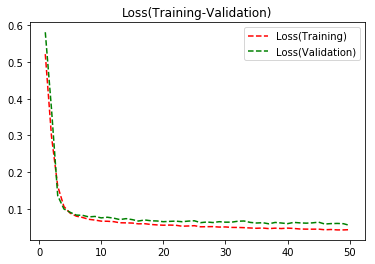

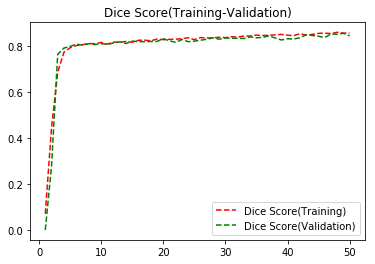

In [10]:
config = Config()
config.BASE_LR = 0.001
config.WEIGH_DECAY = 0.0005
config.NUM_EPOCHES = 50
config.MODEL_DIR = '/disk2/Faliu/pyTorch/holo/uNet/results/trainedModel'
config.RESULTS_DIR = '/disk2/Faliu/pyTorch/holo/uNet/results/predictedImages'
config.display()


# calculate average and standard devation
avg,std = calculate_avg_std(config.IMG_FOLDER)
train_dataset = HoloDataset(config,
                            avg,
                            std,
                            has_augment=transforms.Compose([ImgAugmentation(),ToTensor()])
                            ) 
config2 = Config()
config2.IMG_FOLDER = '/disk2/Faliu/pyTorch/holo/data/data40x/val'
val_dataset = HoloDataset(config2,
                          avg,
                          std,
                          has_augment=transforms.Compose([ToTensor()])
                         )

if torch.cuda.is_available() & config.GPU_COUNT:
    device = torch.device("cuda", index=config.WHICH_GPU)
else:
    print("Using CPU to train the model!")
    device = torch.device("cpu")
    
net = UNet(1,2)
net.to(device)
cudnn.benchmark = True

# training
start_time = timer()
loss_history,accuracy_history,dice_history,val_loss,val_accuracy,val_dice_score = train(config,net,train_dataset,val_dataset,shuffle=True)
end_time = timer()
print('Training Time: {}'.format(end_time - start_time))
# print('Training Accuracy: {}'.format(accuracy_history))
# print('Validation Accuracy: {}'.format(val_accuracy))


epoch_index = np.arange(1, config.NUM_EPOCHES+1, 1)
plt.figure()
plt.plot(epoch_index, loss_history, 'r--')
plt.plot(epoch_index, val_loss, 'g--')
plt.title("Loss(Training-Validation)")
plt.gca().legend(('Loss(Training)','Loss(Validation)'))
plt.show()


plt.figure()
plt.plot(epoch_index, dice_history, 'r--')
plt.plot(epoch_index, val_dice_score, 'g--')
plt.title("Dice Score(Training-Validation)")
plt.gca().legend(('Dice Score(Training)','Dice Score(Validation)'))
plt.show()


### 6.1) Inference for testing dataset

Predicted Cell Number: 15
Correctly Predicted Cell Number: 15
True Cell Number:15


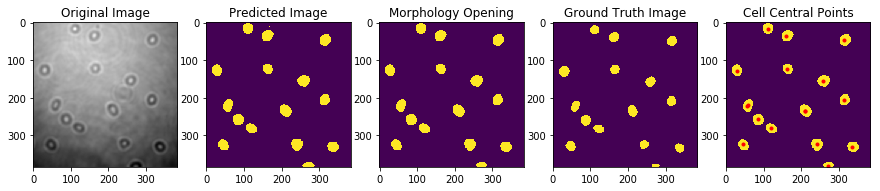

Predicted Cell Number: 12
Correctly Predicted Cell Number: 12
True Cell Number:12


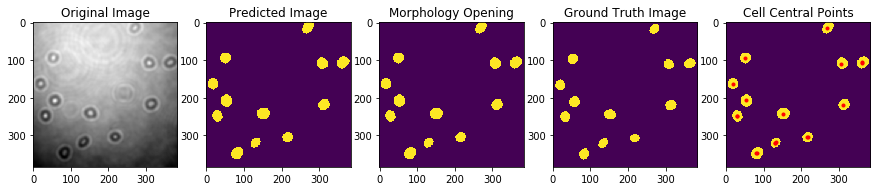

Predicted Cell Number: 15
Correctly Predicted Cell Number: 15
True Cell Number:15


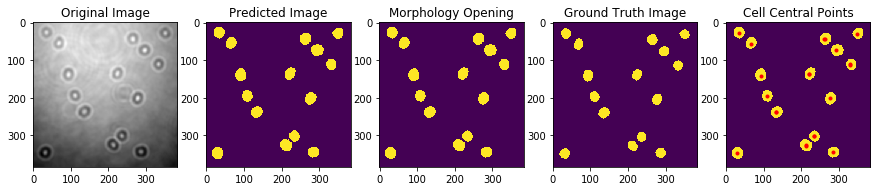

Predicted Cell Number: 13
Correctly Predicted Cell Number: 13
True Cell Number:16


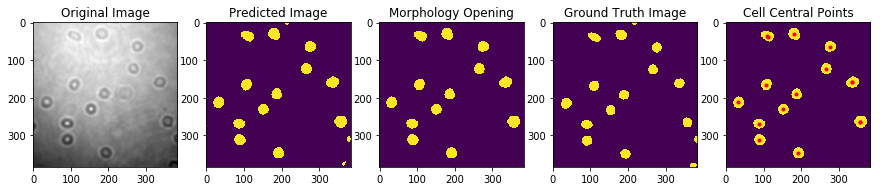

Predicted Cell Number: 14
Correctly Predicted Cell Number: 14
True Cell Number:14


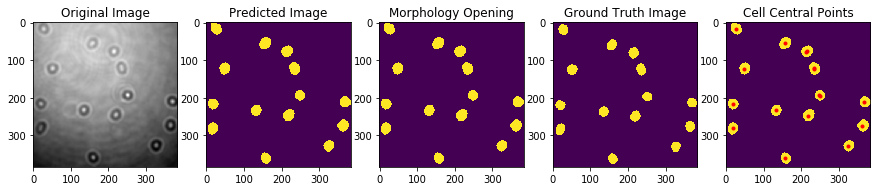

Predicted Cell Number: 12
Correctly Predicted Cell Number: 12
True Cell Number:12


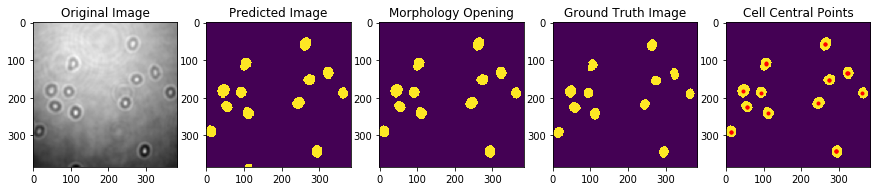

Predicted Cell Number: 16
Correctly Predicted Cell Number: 16
True Cell Number:16


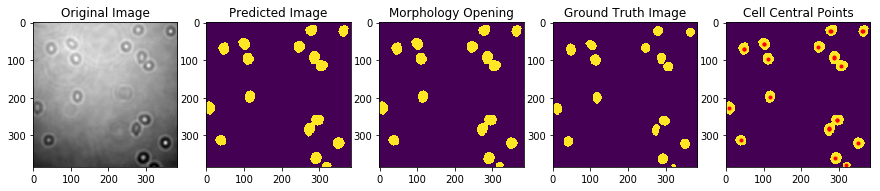

Predicted Cell Number: 15
Correctly Predicted Cell Number: 15
True Cell Number:15


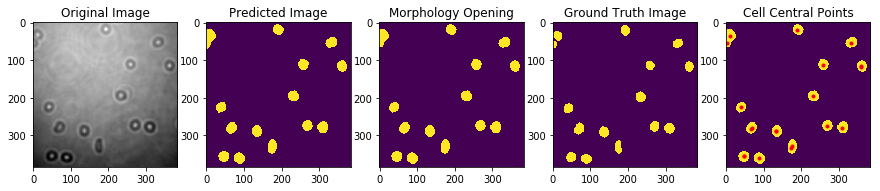

Predicted Cell Number: 14
Correctly Predicted Cell Number: 14
True Cell Number:14


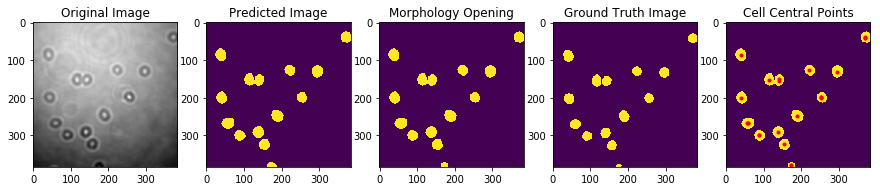

Predicted Cell Number: 12
Correctly Predicted Cell Number: 12
True Cell Number:14


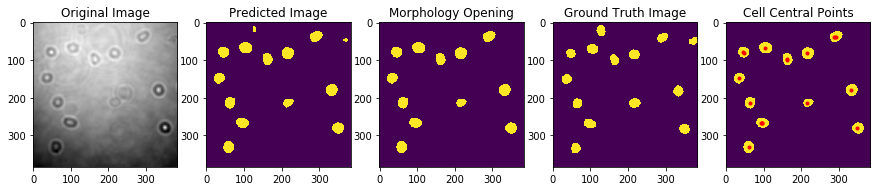

Predicted Cell Number: 13
Correctly Predicted Cell Number: 13
True Cell Number:13


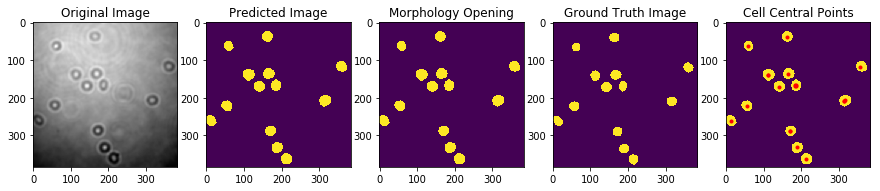

Predicted Cell Number: 12
Correctly Predicted Cell Number: 12
True Cell Number:12


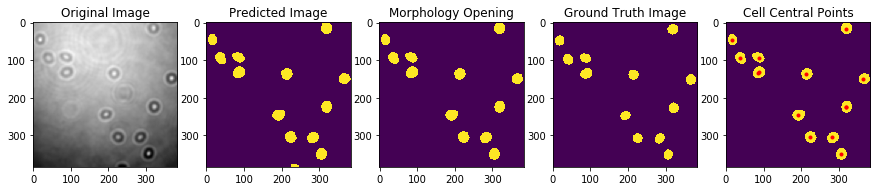

Predicted Cell Number: 12
Correctly Predicted Cell Number: 11
True Cell Number:11


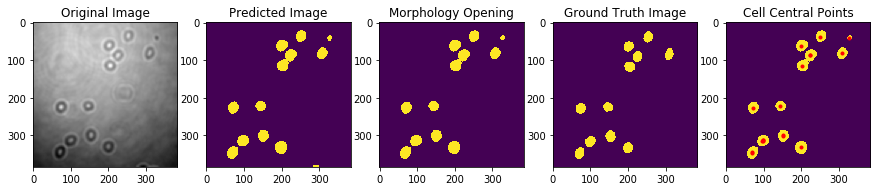

Predicted Cell Number: 14
Correctly Predicted Cell Number: 13
True Cell Number:13


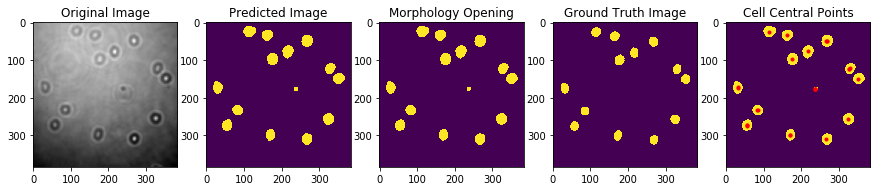

Predicted Cell Number: 16
Correctly Predicted Cell Number: 15
True Cell Number:16


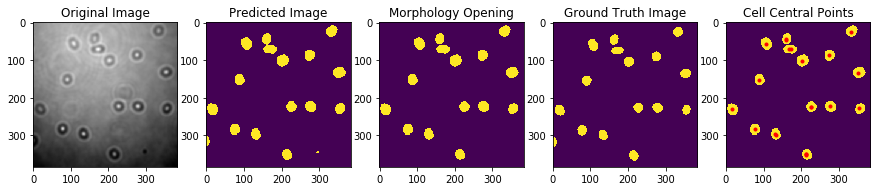

Predicted Cell Number: 15
Correctly Predicted Cell Number: 15
True Cell Number:15


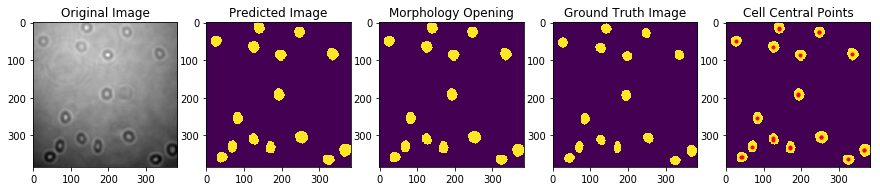

Predicted Cell Number: 12
Correctly Predicted Cell Number: 12
True Cell Number:12


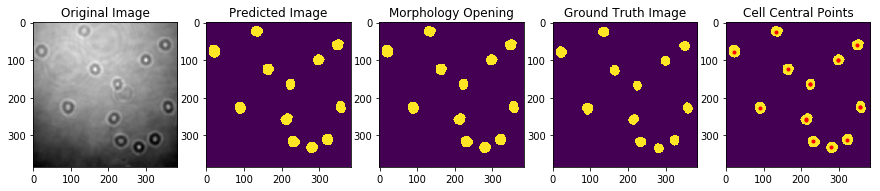

Predicted Cell Number: 17
Correctly Predicted Cell Number: 17
True Cell Number:17


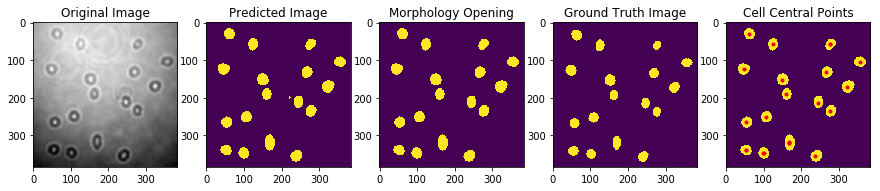

Predicted Cell Number: 15
Correctly Predicted Cell Number: 15
True Cell Number:15


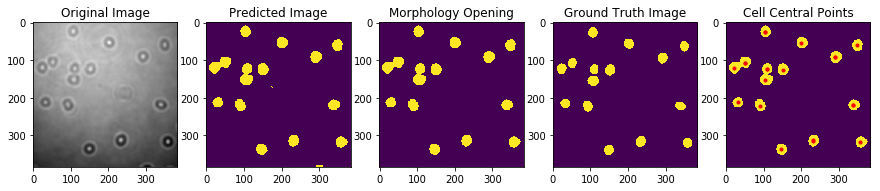

Predicted Cell Number: 16
Correctly Predicted Cell Number: 16
True Cell Number:16


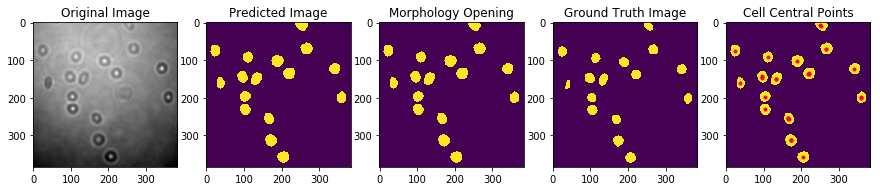

Predicted Cell Number: 13
Correctly Predicted Cell Number: 13
True Cell Number:13


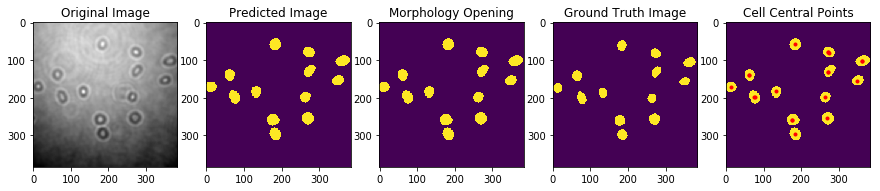

Predicted Cell Number: 17
Correctly Predicted Cell Number: 17
True Cell Number:17


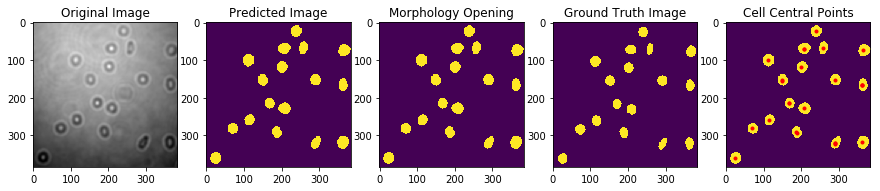

Predicted Cell Number: 12
Correctly Predicted Cell Number: 12
True Cell Number:13


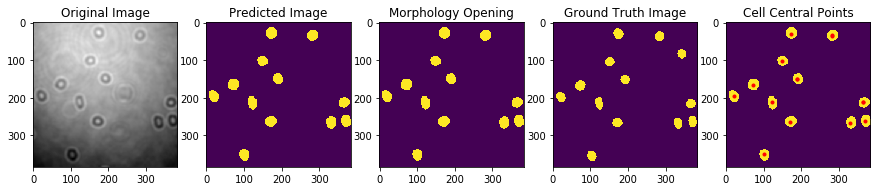

Predicted Cell Number: 18
Correctly Predicted Cell Number: 18
True Cell Number:18


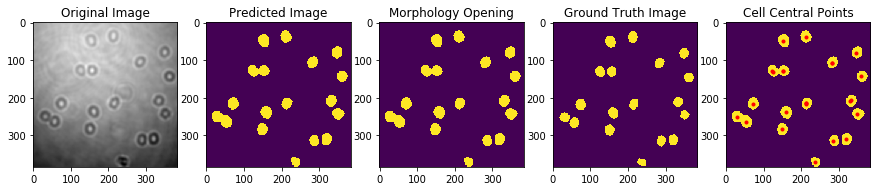

Predicted Cell Number: 16
Correctly Predicted Cell Number: 15
True Cell Number:15


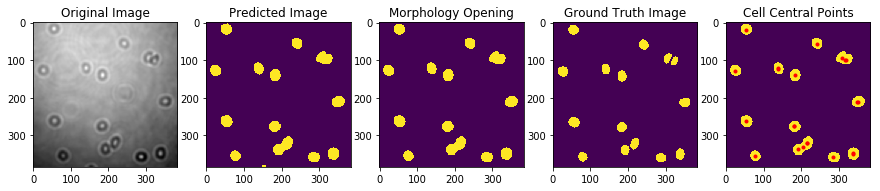

inference time: 0.0984819275992
True Cell Num:359, Predicted Cell Num: 356, Correctly Predicted Cell Num: 352
Total Missed Cell Num: 7, Total Wrong Counted Cell Num:4
Average Missed Cell Num: 0.28. Average Wrong Counted Cell Num:0.16
Accuracy: [0.98147515 0.98285808 0.95662647], Dice Score:0.84707079296


In [11]:
config.IMG_FOLDER = '/disk2/Faliu/pyTorch/holo/data/data40x/test'
test_dataset = HoloDataset(config,
                           avg,
                           std,
                           has_augment=transforms.Compose([ToTensor()])
                          )
save_results_to = config.RESULTS_DIR
if not os.path.exists(save_results_to):
    os.makedirs(save_results_to)
    
PATH = config.MODEL_DIR + os.sep + 'UNet.pth'
net.load_state_dict(torch.load(PATH))
infer(config,net,test_dataset,save_results_to)